# Neural Machine Translation with Attention

- Attention model에 대해서 간략히 설명하고 keras와 eager execution을 통해서 Korean to English 번역기를 만들어 보겠습니다.

## Attention Model 기본 설명

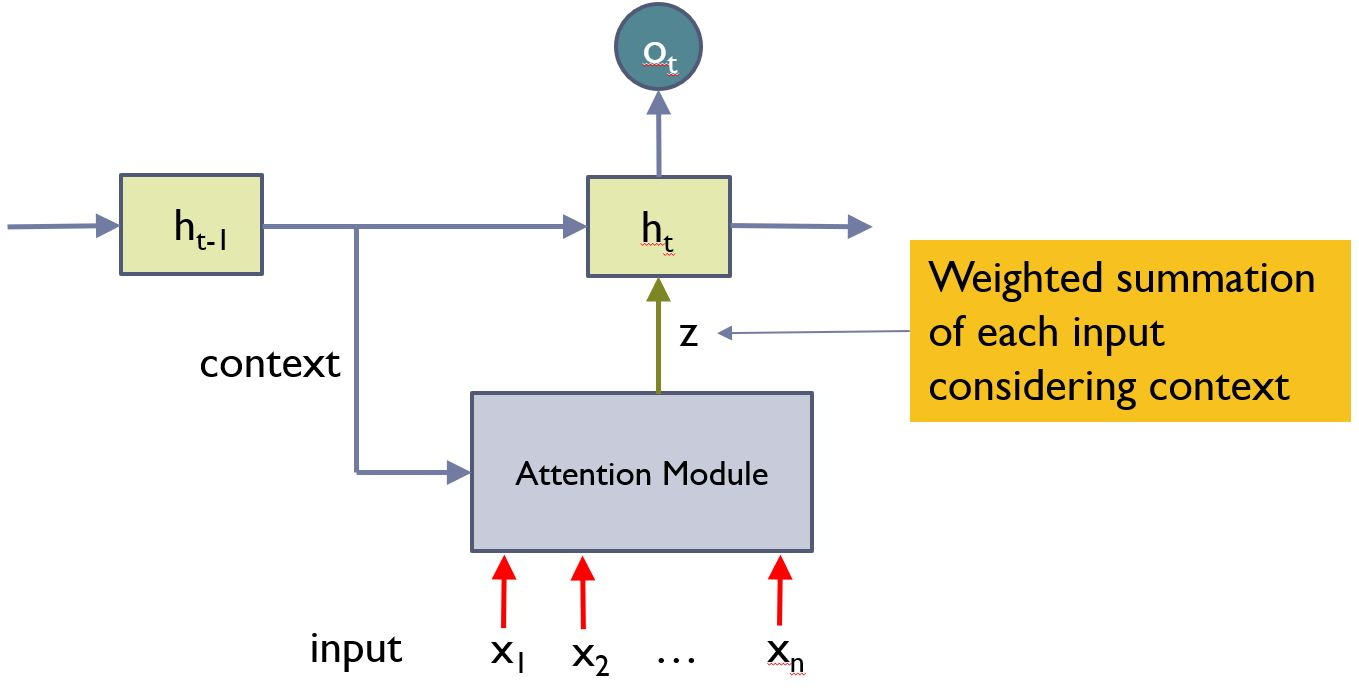

### 1)"I go to school" 이라는 문장을 "나는 학교 에 간다"로 번역을 한다면, h(t-1)에서 "나는"이라는 O(t-1) 결과값이 나왔으면 context는 "나는"의 벡터가 들어간다.
### 2) input에는 x1~x4까지 "I"벡터, "go"벡터,  "to"벡터, "school"벡터가 모든 Attention Module에 동일하게 들어간다.
### 3) 좀더 자세하게 inside를 보면

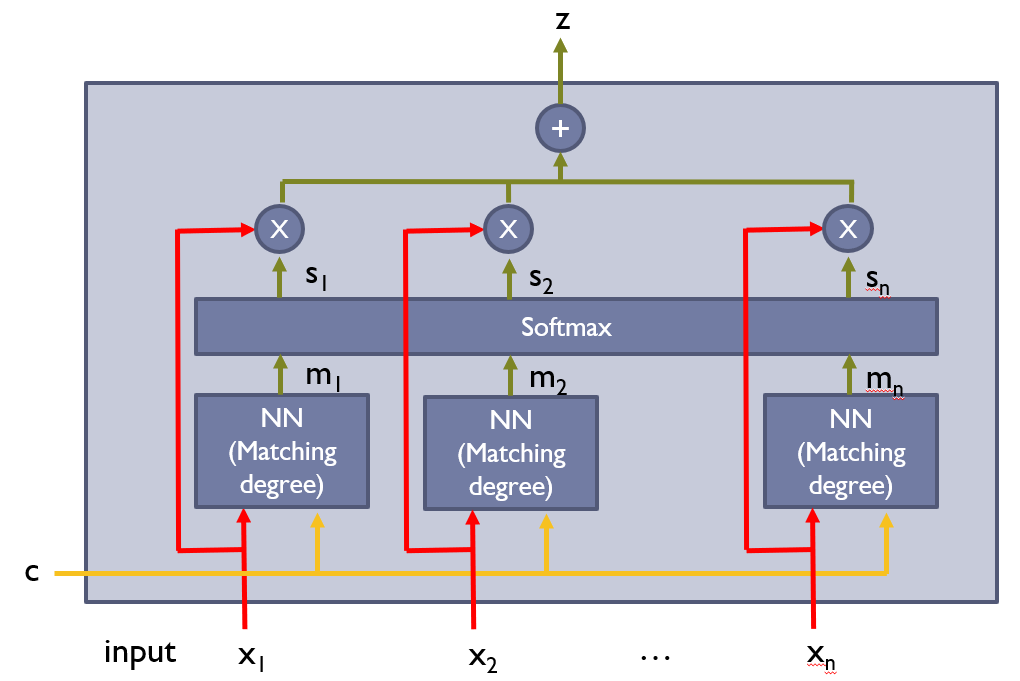

- **c: "나는"의 벡터값**
- **x1: "I" 벡터값 [1,0,0,0],  x2: "go" 벡터값 [0,1,0,0], x3: "to" 벡터값 [0,0,1,0], x4: "school" 벡터값 [0,0,0,1]**

### 첫번째, NN(Matching degree)에서 inner product를 Matching degree를 측정한다 치면 m1은 "나는"과 "I"의 연관도를 출력한다.
### 두번째, m1, ..., m4까지 Matching degree를 출력하고 Softmax에 넣어서 확률합이 "1"이되도록 s1, ...,s4를 출력한다.
### 세번째, "나는" 다음에 "학교"를 예측해야하므로 s4의 확률이 높게 나와야한다.(처음에는 아니겠지만)
- 예를 들어 s1은 0.05, s2는 0.1, s3는 0.05, s4는 0.8이 나온다고 하면

### 네번째, x4인 "school"에 s4(0.8)을 해주면 x4에 Attention이 될 것이다.


In [10]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

c:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Futu

1.13.2


## 데이터셋 다운로드
- http://www.manythings.org/anki/
- 해당 데이터를 보면 전처리가 필요하다.
- 1) 각 문장에 시작과 끝을 알리는 토큰 추가
- 2) 특수문자 제거
- 3) 단어 색인 및 역 단어 색인 (단어-id, id-단어)
- 4) 각 문장을 최대 길이까지 채움

```
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
```

### 한글이 다운로드 안되서 그냥 다운로드 받아 압축품

In [24]:
# Download the file
path_to_zip = './data'
path_to_file = os.path.dirname(path_to_zip) + "/kor-eng/kor.txt"

## 전처리 하기

In [27]:
# Convert the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

- 유니코드 정규화는 모양이 같은 여러 문자들이 있을 경우 이를 기준에 따라 하나로 통합해 주는 일을 가리킨다. 그 기준으로는 아래 표와 같이 NFD, NFC, NFKD, NFKC가 있다.
- NFD로의 정규화 : 코드를 정준 분해한다
###### 한글을 한글 소리마디 영역(U+AC00~U+D7A3)으로 썼을 경우, 이를 첫가끝 코드로 처리하기
- 위 (U+C704) → ᄋ (U+110B) + ᅱ (U+1171)
- 한 (U+D55C) → ᄒ (U+1112) + ᅡ (U+1161) + ᆫ (U+11AB)
```
unicodedata.normalize('NFD', '한글')
```

In [69]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # 단어와 부호 간의 한칸 띄우기 아래에 (예시1) 참조
    w = re.sub(r"([?.!])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 공간을 공백으로 교체
    w = re.sub(r"[^[가-힣]?.!]+", " ", w)   #알파벳:^a-zA-Z, 한글:^[가-힣]
    w = w.rstrip().strip()
    w = '<start>' + w + '<end>'
    
    return(w)

(예시1)
```
w = "나는 학교!에 간!  > < 다?   ?."
w = re.sub(r"([?.!])", r" \1 ", w)
w1 = re.sub(r'[" "]+', " ", w)
w2 = re.sub(r"[^[가-힣]?.!]+", " ", w)
w3 = w2.rstrip().strip()
w4 = '<start>' + w3 + '<end>'
```
ouput
```
나는 학교 ! 에 간 !   > < 다 ?     ?  . 
나는 학교 ! 에 간 ! > < 다 ? ? . 
나는 학교 ! 에 간 !   > < 다 ?     ?  . 
나는 학교 ! 에 간 !   > < 다 ?     ?  .
<start>나는 학교 ! 에 간 !   > < 다 ?     ?  .<end>
```

- 1) 악센트 제거
- 2) 문장을 정리
- 3) 단어 쌍으로 반환(단어와 index, index와 단어 맵핑)

In [70]:
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in I.split('\t')] 
                  for I in lines[:num_examples]]
    
    return word_pairs

```
lines = ["school\t학교", "bat\t방망이", "car\t자동차"]
num_examples = 4
word_pairs = [[preprocess_sentence(w) for w in I.split('\t')]
             for I in lines[:num_examples]]
=
word_pairs = []
for I in lines[:num_examples]:
    word = []
    for w in I.split('\t'):
        word.append(preprocess_sentence(w))
    word_pairs.append(word)
print(word_pairs)
        ```

In [117]:
# index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
            
        self.vocab = sorted(self.vocab)
        
        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1
        
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

- update는 집합에서 가능
```
a = ["나는 학교에 간다.", "엄마 어딨어요?", "우리들은 1학년"]
voca = set()
for p in a:
    voca.update(p.split(' '))
print(voca)
```
output
```
{'1학년', '간다.', '나는', '어딨어요?', '엄마', '우리들은', '학교에'}
```

```
a = ["나는 학교에 간다.", "엄마 어딨어요?", "우리들은 1학년"]
voca = set()
for p in a:
    voca.update(p.split(' '))
# voca : {'나는', '엄마', '우리들은', '1학년', '어딨어요?', '학교에', '간다.'}
voca = sorted(voca)
# voca : ['1학년', '간다.', '나는', '어딨어요?', '엄마', '우리들은', '학교에']
w2i = {}
i2w = {}
w2i['<pad>'] = 0
for index, word in enumerate(voca):
    w2i[word] = index + 1
for word, index in w2i.items():
    i2w[index] = word
```
output
```
{'<pad>': 0,
 '1학년': 1,
 '간다.': 2,
 '나는': 3,
 '어딨어요?': 4,
 '엄마': 5,
 '우리들은': 6,
 '학교에': 7}
 ```
 ```
 {0: '<pad>',
 1: '1학년',
 2: '간다.',
 3: '나는',
 4: '어딨어요?',
 5: '엄마',
 6: '우리들은',
 7: '학교에'}
 ```

In [113]:
w2i.keys()

dict_keys(['<pad>', '1학년', '간다.', '나는', '어딨어요?', '엄마', '우리들은', '학교에'])

In [115]:
w2i.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7])

In [116]:
w2i.items()

dict_items([('<pad>', 0), ('1학년', 1), ('간다.', 2), ('나는', 3), ('어딨어요?', 4), ('엄마', 5), ('우리들은', 6), ('학교에', 7)])